In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 4070 Ti


In [3]:

class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")  
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)  

# Multi-label encoder function
def encode_labels(label_string, label_map):
    labels = label_string.split('|')
    encoded = np.zeros(len(label_map))
    for label in labels:
        if label in label_map:
            encoded[label_map[label]] = 1
    return encoded

# label map
label_map = {
    "No Finding": 0,
    "Atelectasis": 1,
    "Cardiomegaly": 2,
    "Consolidation": 3,
    "Edema": 4,
    "Effusion": 5,
    "Emphysema": 6,
    "Fibrosis": 7,
    "Hernia": 8,
    "Infiltration": 9,
    "Mass": 10,
    "Nodule": 11,
    "Pleural_Thickening": 12,
    "Pneumonia": 13,
    "Pneumothorax": 14,
}

df_uo = pd.read_csv(r"C:\\Users\\Adam\\Downloads\\ChestXray\\Data_Entry_2017.csv")
image_folder = "C:\\Users\\Adam\\Downloads\\ChestXray\\train_val_images" 
image_filenames = set(os.listdir(image_folder))
df_filtered = df_uo[df_uo['Image Index'].isin(image_filenames)]
df_filtered = df_filtered.reset_index(drop=True)
df = df_filtered

img_test_folder = "C:\\Users\\Adam\\Downloads\\ChestXray\\test_images" 
image_filenames_test = set(os.listdir(img_test_folder))
df_filtered = df_uo[df_uo['Image Index'].isin(image_filenames_test)]
df_filtered = df_filtered.reset_index(drop=True)
df_test = df_filtered


df_test.head(50)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000003_007.png,Hernia,7,3,80,F,PA,2582,2905,0.143000,0.143000,NaN
1,00000013_046.png,Infiltration,46,13,56,M,PA,2730,2991,0.143000,0.143000,NaN
2,00000032_060.png,Cardiomegaly|Edema,60,32,55,F,AP,2500,2048,0.168000,0.168000,NaN
3,00000041_006.png,Effusion,6,41,62,F,PA,2276,2441,0.143000,0.143000,NaN
4,00000072_000.png,Atelectasis,0,72,67,F,PA,2450,2839,0.143000,0.143000,NaN
5,00000092_003.png,Fibrosis,3,92,58,F,PA,2992,2991,0.143000,0.143000,NaN
6,00000116_040.png,Cardiomegaly|Consolidation,40,116,75,F,AP,2500,2048,0.168000,0.168000,NaN
7,00000147_002.png,Atelectasis|Effusion|Pleural_Thickening,2,147,67,F,AP,2500,2048,0.168000,0.168000,NaN
8,00000149_009.png,No Finding,9,149,70,M,PA,2838,2991,0.143000,0.143000,NaN
9,00000150_005.png,No Finding,5,150,55,F,AP,3056,2544,0.139000,0.139000,NaN


In [5]:
# Preprocessing and splitting
image_dir = "C:\\Users\\Adam\\Downloads\\ChestXray\\train_val_images"
image_paths = [os.path.join(image_dir, fname) for fname in df['Image Index']]
labels = [encode_labels(lbl, label_map) for lbl in df['Finding Labels']]


img_test_dir = "C:\\Users\\Adam\\Downloads\\ChestXray\\test_images"
image_paths_test = [os.path.join(img_test_dir, fname) for fname in df_test['Image Index']]
test_labels = [encode_labels(lbl, label_map) for lbl in df_test['Finding Labels']]


# Define transformations for image preprocessing (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print(np.transpose(test_labels[2]))

[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create custom datasets and DataLoader for batching
train_dataset = ChestXrayDataset(X_train, y_train, transform=transform)
val_dataset = ChestXrayDataset(X_val, y_val, transform=transform)
test_dataset = ChestXrayDataset(image_paths_test, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False)

# Define the PyTorch model for multi-label classification
class MultiLabelCNN(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_labels)  # Output layer with one node per label
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for multi-label classification
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)  # Apply sigmoid activation for multi-label output
        return x

print(y_train[50])
print(np.sum(y_train,axis=0))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[14796.  1516.   506.   418.   122.  1431.   203.   360.    45.  3008.
   850.  1125.   537.   166.   280.]


In [ ]:
# Create the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelCNN(num_labels=len(label_map)).to(device)
class_counts = torch.tensor([14796., 1516., 506., 418., 122., 1431., 203., 360., 45., 3008., 850., 1125., 537., 166., 280.])
total_samples = class_counts.sum()
class_weights = total_samples / class_counts
class_weights = class_weights / class_weights.max()



criterion = nn.BCEWithLogitsLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Convert outputs to binary predictions
            predicted = (outputs > 0.3).float()
            correct += (predicted == targets).sum().item()
            total += targets.numel()
    
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print("Training done")
torch.save(model.state_dict(), 'model_B.pth')

Epoch [1/1], Loss: 0.1202
Validation Loss: 0.1201
Validation Accuracy: 94.48%
Training done


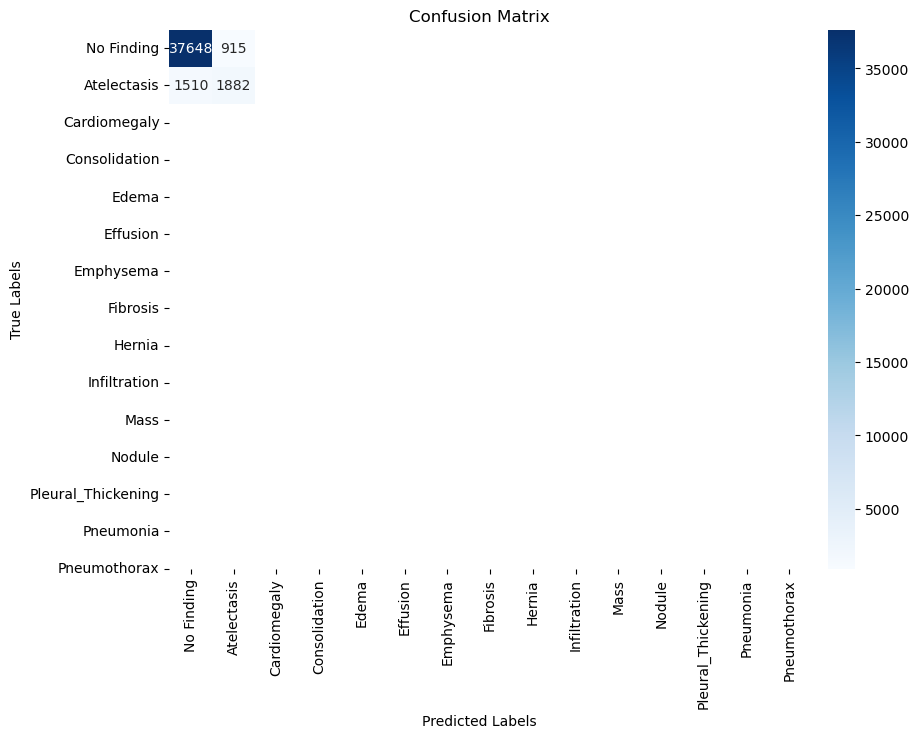

Test Loss: 0.1201
Test Accuracy: 94.22%
F1 score (micro): 0.6081757957666828


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()  
test_loss = 0.0
correct = 0
total = 0

all_true_labels = []
all_pred_labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        predicted = (outputs > 0.1).float()
        correct += (predicted == targets).sum().item()
        total += targets.numel()
        all_true_labels.append(targets.cpu().numpy())
        all_pred_labels.append(predicted.cpu().numpy())


all_true_labels = np.concatenate(all_true_labels, axis=0)
all_pred_labels = np.concatenate(all_pred_labels, axis=0)

cm = confusion_matrix(all_true_labels.flatten(), all_pred_labels.flatten())

# confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate test loss and accuracy
test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


from sklearn.metrics import f1_score
f1 = f1_score(all_true_labels, all_pred_labels, average='micro')  # or 'macro' for unweighted
print(f"F1 score (micro): {f1}")

In [26]:
f1 = f1_score(all_true_labels, all_pred_labels,average=None)  # or 'macro' for unweighted
print(f"F1 score: {f1}")
print(class_weights)

F1 score: [0.80444539 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
tensor([0.0030, 0.0297, 0.0889, 0.1077, 0.3689, 0.0314, 0.2217, 0.1250, 1.0000,
        0.0150, 0.0529, 0.0400, 0.0838, 0.2711, 0.1607])
